<a href="https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/05_aipi590_xai_livermrcnnmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b colabversion 'https://github.com/mille055/stanford_project.git'




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 19.9 MB/s eta 0:00:00
Cloning into 'stanford_project'...
remote: Enumerating objects: 2922, done.
remote: Counting objects: 100% (677/677), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 2922 (delta 477), reused 601 (delta 414), pack-reused 2245 (from 1)
Receiving objects: 100% (2922/2922), 384.51 MiB | 15.44 MiB/s, done.
Resolving deltas: 100% (2077/2077), done.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

from PIL import Image


In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'

    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2, data_transforms3, data_transforms4

from model_container import ModelContainer



Mounted at /content/gdrive


# Create Datasets and DataLoaders

In [ ]:

#create the datasets
#train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



Creating an alternative dataframe where the val images are randomly chosen rather than the midpoint as originally performed. Also, creating a larger train dataset to explore.

In [ ]:
# val_ran_df = create_dataset(val_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/', selection_behavior = 'random', a=0.1, b=0.9)
# train_large_df = create_dataset(train_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/', selection_behavior='range', a=0.1, b=0.9)

# val_ran_df.to_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')
# train_large_df.to_pickle('/content_grdive/MyDrive/train_large_df.pkl')

In [ ]:
# val_ran_df
# val_ran_df.to_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')

In [6]:
# have already pickled the datasets and just loading here
train_df = pd.read_pickle('/content/gdrive/MyDrive/train_df.pkl')
val_df = pd.read_pickle('/content/gdrive/MyDrive/val_df.pkl')
test_df = pd.read_pickle('/content/gdrive/MyDrive/test_df.pkl')
val_ran_df = pd.read_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')

In [7]:
# Get the data loaders
# dataloaders - vanilla, no augmentation just cropping and resizing, number channels to 1, and to tensor
# dataloaders2 - some augmentation (color jitter)
# dataloaders3 - some augmentation (color jitter) as well as use of a gamma filter with parameter = 2 to highlight bright pixels
# dataloaders4 - some augmentation (color jitter) as well as use of a gamma filter with parameter = 0.5 for comparison

batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
train_loader3, val_loader3, test_loader3, dataset_sizes3 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms3)
train_loader4, val_loader4, test_loader4, dataset_sizes4 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms4)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}
dataloaders3 = {'train': train_loader3, 'val': val_loader3, 'test': test_loader3}
dataloaders4 = {'train': train_loader4, 'val': val_loader4, 'test': test_loader4}


# Explore Base Model Archictectures#

Comparing the accuracy of various models on the validation dataset. There are two variations of the ResNet50 model, the first (CustomResNet) with a single fully connected layer as the head and the second (CustomResNetb) with two fully connected layers separated by ReLU. There is also a DenseNet model with a single fully connected layer as the head. Both SGD and Adam optimizers are used for each combination, as are Cross Entropy Loss and a custom Focal Loss.

For data preparation, there are four different combinations: a vanilla transformer that only uses cropping and resizing, transformer2 which also uses some augmentation (color jitter), and transformers 3 and 4 which use a gamma function to alter the image (presumably to highlight bright pixels) with two different settings for comparison (although will likely perform the last comparison only on the 'best model' from the other comparisons.

In [10]:
# Different combinations to evaluate
models = [CustomDenseNet] #CustomResNet50, CustomResNet50b, CustomDenseNet]
loss_funcs = [FocalLoss]  #nn.CrossEntropyLoss, FocalLoss]
loaders = ['dataloaders2']
loaders_dict = {'dataloaders': dataloaders, 'dataloaders2': dataloaders2, 'dataloaders3': dataloaders3}
optimizers = ['Adam'] # 'SGD'
optim_dict = {
    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}



Training with CustomDenseNet, dataloaders2, Adam, FocalLoss


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 188MB/s]


Epoch 0/14
----------
train Loss: 1.0459 Acc: 0.5610
val Loss: 0.9130 Acc: 0.5819

Epoch 1/14
----------
train Loss: 0.5829 Acc: 0.7085
val Loss: 0.7940 Acc: 0.6695

Epoch 2/14
----------
train Loss: 0.4341 Acc: 0.7655
val Loss: 0.5471 Acc: 0.7514

Epoch 3/14
----------
train Loss: 0.3298 Acc: 0.8042
val Loss: 0.6376 Acc: 0.6949

Epoch 4/14
----------
train Loss: 0.2640 Acc: 0.8378
val Loss: 0.8861 Acc: 0.6215

Epoch 5/14
----------
train Loss: 0.1834 Acc: 0.8729
val Loss: 0.4822 Acc: 0.7514

Epoch 6/14
----------
train Loss: 0.2160 Acc: 0.8605
val Loss: 0.8467 Acc: 0.6921

Epoch 7/14
----------
train Loss: 0.1161 Acc: 0.9123
val Loss: 0.2876 Acc: 0.8362

Epoch 8/14
----------
train Loss: 0.0645 Acc: 0.9533
val Loss: 0.2804 Acc: 0.8531

Epoch 9/14
----------
train Loss: 0.0432 Acc: 0.9613
val Loss: 0.2512 Acc: 0.8616

Epoch 10/14
----------
train Loss: 0.0377 Acc: 0.9708
val Loss: 0.2527 Acc: 0.8701

Epoch 11/14
----------
train Loss: 0.0332 Acc: 0.9701
val Loss: 0.2657 Acc: 0.8701

Ep

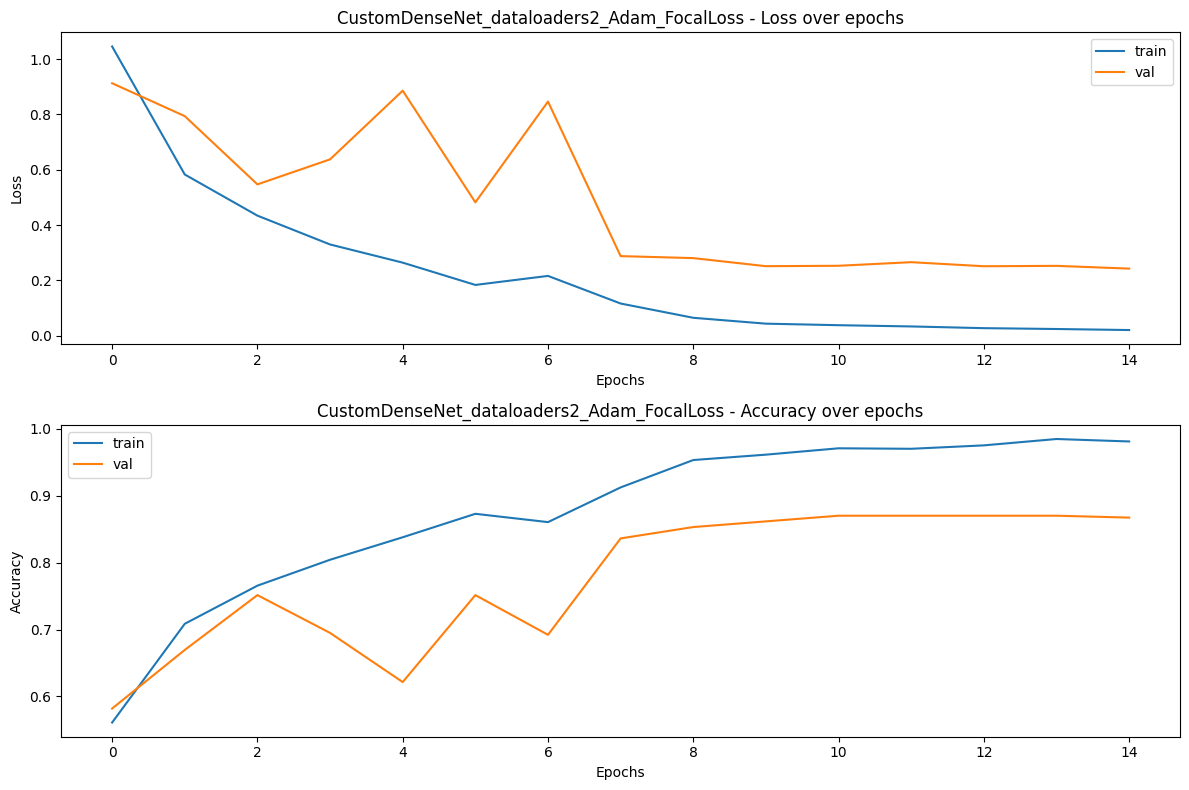

In [11]:
# perform several training runs to compare accuracy on the validation dataset
best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function
                criterion = loss_func_class()

                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)

                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_combo = combination_name
                  best_accuracy = best_val_accuracy


In [12]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):


    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)

    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))


    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("/content/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')

    return cm



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           2       0.88      0.90      0.89        49
           6       0.88      1.00      0.93        14
           7       0.94      0.94      0.94        18
           8       1.00      0.89      0.94        35
           9       0.92      0.97      0.94        34
          11       1.00      0.95      0.97        20
          12       1.00      0.08      0.15        12
          13       1.00      0.33      0.50         3
          14       0.86      0.95      0.90        19
          16       0.63      0.60      0.62        20
          17       0.94      1.00      0.97        17
          18       0.95      0.95      0.95        22
          19       1.00      0.89      0.94        19
          23       0.62      0.53      0.57        19
          25       0.69   

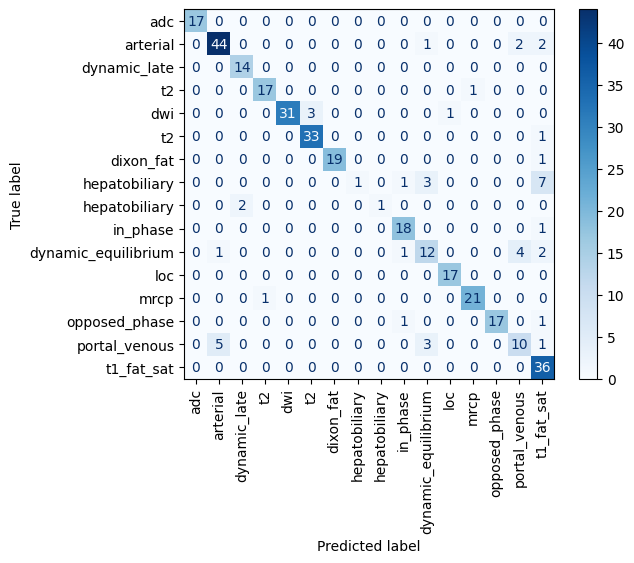

<Figure size 2500x2500 with 0 Axes>

In [13]:
# Evaluate the model on the val dataset
model = best_model

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)


save_filename = f"cnn_model_{best_combo}_{datetime.now().strftime('%Y%m%d')}.pth"

cm = display_and_save_results2(val_predictions, val_labels, classes, fn=save_filename, saveflag=True)

# Save the trained model if needed

torch.save(trained_model.state_dict(), f'/content/gdrive/MyDrive/{save_filename}')




In [14]:


torch.save(best_model.state_dict(), '/content/gdrive/MyDrive/best_model_cnn_0930.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.90      0.85      0.87        61
           6       0.89      1.00      0.94        17
           7       0.96      1.00      0.98        22
           8       0.95      0.98      0.97        43
           9       0.98      0.95      0.96        42
          11       1.00      1.00      1.00        29
          12       0.33      0.10      0.15        10
          13       1.00      0.33      0.50         3
          14       0.95      0.83      0.88        23
          16       0.68      0.68      0.68        22
          17       1.00      0.95      0.98        21
          18       1.00      0.96      0.98        28
          19       0.82      1.00      0.90        23
          23       0.44      0.60      0.51        20
          25       0.92   

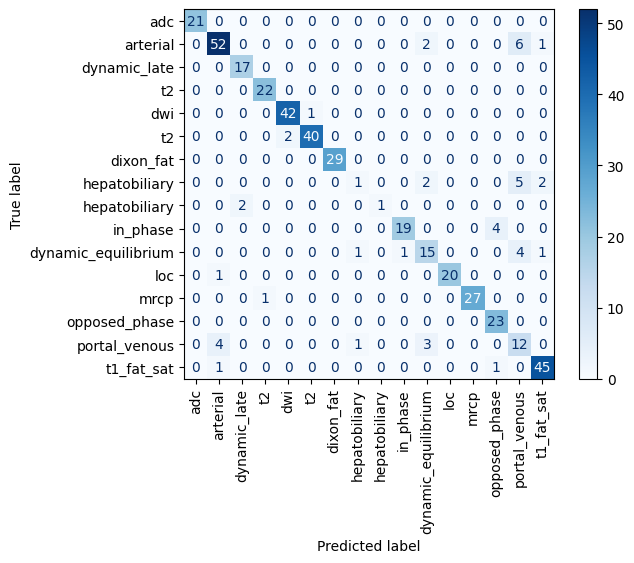

<Figure size 2500x2500 with 0 Axes>

In [16]:

# Download the saved model from Google Drive
from google.colab import files

files.download('/content/gdrive/MyDrive/best_model_cnn_0930.pth')

# Load the downloaded model
model = CustomDenseNet(num_classes=len(classes))
model.load_state_dict(torch.load('/content/gdrive/MyDrive/best_model_cnn_0930.pth'))
model.to(device)
model.eval()


# Make predictions on the test set
test_predictions = []
test_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_predictions.append(predicted.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_predictions = np.concatenate(test_predictions, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Evaluate the model's performance on the test set
cm = display_and_save_results2(test_predictions, test_labels, classes, fn='test_results', saveflag=True)


In [17]:
# prompt: I want to use anchors to evaluate this classification model

import numpy as np
def calculate_anchor_metrics(model, dataloader, device, threshold=0.5):
  """
  Calculates anchor-based metrics for a classification model.

  Args:
      model: The classification model.
      dataloader: The DataLoader for the dataset.
      device: The device (CPU or GPU) to use for calculations.
      threshold: The probability threshold for considering a prediction positive.

  Returns:
      A dictionary containing anchor-based metrics such as precision, recall, F1-score.
  """

  model.eval()
  y_true = []
  y_pred = []
  y_probs = []

  for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad():
          outputs = model(inputs)
          probs = torch.softmax(outputs, dim=1)
          predicted_labels = (probs > threshold).int()

          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted_labels.cpu().numpy())
          y_probs.extend(probs.cpu().numpy())

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  y_probs = np.array(y_probs)

  # Calculate metrics for each class
  metrics_per_class = {}
  for class_idx in range(y_probs.shape[1]):
      true_positives = np.sum((y_true == class_idx) & (y_pred[:, class_idx] == 1))
      false_positives = np.sum((y_true != class_idx) & (y_pred[:, class_idx] == 1))
      false_negatives = np.sum((y_true == class_idx) & (y_pred[:, class_idx] == 0))

      precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
      recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
      f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

      metrics_per_class[class_idx] = {
          'precision': precision,
          'recall': recall,
          'f1_score': f1_score
      }

  return metrics_per_class


# Example usage:
metrics = calculate_anchor_metrics(model, val_loader, device)

# Print the results:
for class_idx, class_metrics in metrics.items():
    print(f"Class {class_idx}:")
    print(f"  Precision: {class_metrics['precision']:.4f}")
    print(f"  Recall: {class_metrics['recall']:.4f}")
    print(f"  F1-Score: {class_metrics['f1_score']:.4f}")



Class 0:
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Class 1:
  Precision: 0.9111
  Recall: 0.8367
  F1-Score: 0.8723
Class 2:
  Precision: 0.8667
  Recall: 0.9286
  F1-Score: 0.8966
Class 3:
  Precision: 0.9412
  Recall: 0.8889
  F1-Score: 0.9143
Class 4:
  Precision: 1.0000
  Recall: 0.8286
  F1-Score: 0.9062
Class 5:
  Precision: 1.0000
  Recall: 0.9118
  F1-Score: 0.9538
Class 6:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
Class 7:
  Precision: 1.0000
  Recall: 0.9000
  F1-Score: 0.9474
Class 8:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
Class 9:
  Precision: 1.0000
  Recall: 0.3333
  F1-Score: 0.5000
Class 10:
  Precision: 0.9474
  Recall: 0.9474
  F1-Score: 0.9474
Class 11:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
Class 12:
  Precision: 0.7143
  Recall: 0.5000
  F1-Score: 0.5882
Class 13:
  Precision: 1.0000
  Recall: 0.9412
  F1-Score: 0.9697
Class 14:
  Precision: 1.0000
  Recall: 0.9091
  F1-Score: 0.9524
Class 15:
  Precisio

In [ ]:

!pip install anchor-exp

from anchor import anchor_tabular


In [26]:
# prompt: I want to use anchors as described at https://github.com/marcotcr/anchor

# Assuming you have your features (X) and labels (y) prepared
# X_train, y_train, X_test, y_test = ...

# Example usage:
# Assuming 'model' is your trained model
def predict_fn(x):
  """Prediction function compatible with Anchor."""
  with torch.no_grad():
    x = torch.tensor(x, dtype=torch.float32).to(device)
    outputs = model(x)
    probs = torch.softmax(outputs, dim=0)
    predicted_label = torch.argmax(probs).item()
  return predicted_label


# Create an explainer
explainer = anchor_tabular.AnchorTabularExplainer(
    classes,  # Class names
    train_df.columns,  # Feature names
    train_df.values  # Training data
)


# Get an explanation for a specific instance
instance = X_test.iloc[0].values
explanation = explainer.explain_instance(instance, predict_fn)


# Print the explanation
print('Anchor: %s' % (' AND '.join(explanation.names())))
print('Precision: %.2f' % explanation.precision())
print('Coverage: %.2f' % explanation.coverage())



TypeError: '<' not supported between instances of 'MultiValue' and 'MultiValue'

#Experiment: gamma filter with different hyperparameter#
Looking at applying a gamma filter on the images with two different settings to see if it affects accuracy. One of the key components that a human looks at is the distribution of bright pixels (and how they correspond to different portions of anatomy), so a gamma filter may affect how bright pixels are accentuated in the image.

In [ ]:
# perform several training runs to compare accuracy on the validation dataset
models_g = [CustomDenseNet]
loss_funcs_g = [FocalLoss]
loaders_g = ['dataloaders3', 'dataloaders4']
optimizers_g = ['Adam']

best_model_g = None
best_accuracy_g = -1

for model_class in models_g:
  for loader in loaders_g:
        for opt in optimizers_g:
            for loss_func_class in loss_funcs_g:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function
                criterion = loss_func_class()

                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)

                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model_g, best_val_accuracy_g, history_g = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history_g['train_loss'])
                print("Validation loss history:", history_g['val_loss'])
                print("Training accuracy history:", history_g['train_acc'])
                print("Validation accuracy history:", history_g['val_acc'])


                # Plot training curves
                combination_name_g = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name_g)

                if best_val_accuracy_g > best_accuracy_g:
                  best_model_g = trained_model_g
                  best_combo_g = combination_name_g
                  best_accuracy_g = best_val_accuracy_g



<All keys matched successfully>

[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.91      0.87      0.89        61
           6       0.85      1.00      0.92        17
           7       0.95      0.95      0.95        22
           8       0.93      1.00      0.97        43
           9       1.00      0.93      0.96        42
          11       1.00      1.00      1.00        29
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         3
          14       0.92      1.00      0.96        23
          16       0.67      0.73      0.70        22
          17       0.95      0.95      0.95        21
          18       1.00      0.96      0.98        28
          19       1.00      1.00      1.00        23
          23       0.48      0.65      0.55        20
          25       0.92   

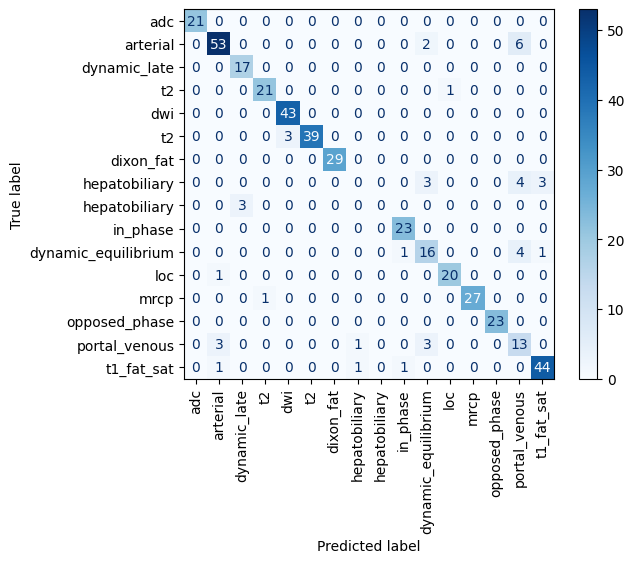

<Figure size 2500x2500 with 0 Axes>

In [ ]:
# Create an instance of the model class
loaded_model = CustomDenseNet()


# Load the saved model
state_dict = torch.load('/content/gdrive/MyDrive/model0530a.pth')


# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)


# Evaluate the model on the test dataset
model = loaded_model.to(device)

model.eval()
test_predictions = []
test_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        test_predictions.append(predicted.cpu().numpy())
        test_labels.append(labels.cpu().numpy())
test_predictions = np.concatenate(test_predictions, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(test_predictions, test_labels, classes, fn='DenseNetFL', saveflag=True)







In [ ]:
test_df['predictions'] = [classes[x] for x in test_predictions]
incorrect_df = test_df.copy()
incorrect_df = incorrect_df[incorrect_df.predictions!=incorrect_df.label]
incorrect_df = incorrect_df.reset_index()
incorrect_df.to_pickle('/content/gdrive/MyDrive/incorrect_df0604a.pkl')
test_df.to_pickle('/content/gdrive/MyDrive/test_with_preds0604a.pkl')

ImageType       SOPClassUID  \
0    [DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]  MR Image Storage   
1    [DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]  MR Image Storage   
2             [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
3             [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
4             [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
..                                            ...               ...   
427  [DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]  MR Image Storage   
428           [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
429           [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
430           [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
431           [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   

        SeriesDescription ContrastBolusAgent BodyPartExamined  \
0          ax diff_TRACEW         Multihance          ABDOMEN   
1          ax diff_TRACEW         Multihance          ABDOMEN   
2      ax equilibrium new         Multihance          ABDOMEN   
3              ax dyn new         Multihance          ABDOMEN   
4              ax dixon_W                NaN          ABDOMEN   
..                    ...                ...              ...   
427        ax diff_TRACEW         MULTIHANCE          ABDOMEN   
428             cor haste                NaN          ABDOMEN   
429            ax dyn new         MULTIHANCE          ABDOMEN   
430           ax dixon_in                NaN          ABDOMEN   
431  ax portal venous new         MULTIHANCE          ABDOMEN   

    ScanningSequence SequenceVariant  ScanOptions MRAcquisitionType AngioFlag  \
0                 EP        [SK, SP]   [PFP, SFS]                2D         N   
1                 EP        [SK, SP]   [PFP, SFS]                2D         N   
2                 GR       [SP, OSP]    [PFP, FS]                3D         N   
3                 GR       [SP, OSP]    [PFP, FS]                3D         N   
4                 GR              SP         DIXW                3D         N   
..               ...             ...          ...               ...       ...   
427               EP        [SK, SP]   [PFP, SFS]                2D         N   
428               SE   [SK, SP, OSP]          PFP                2D         N   
429               GR       [SP, OSP]    [PFP, FS]                3D         N   
430               GR              SP  [PFP, SAT2]                3D         N   
431               GR       [SP, OSP]    [PFP, FS]                3D         N   

     ...                        PixelSpacing  \
0    ...  [2.0833332538605, 2.0833332538605]   
1    ...  [2.0833332538605, 2.0833332538605]   
2    ...                  [0.78125, 0.78125]   
3    ...                  [0.78125, 0.78125]   
4    ...                    [1.5625, 1.5625]   
..   ...                                 ...   
427  ...  [1.9791666269302, 1.9791666269302]   
428  ...                    [1.5625, 1.5625]   
429  ...                  [0.78125, 0.78125]   
430  ...                    [1.5625, 1.5625]   
431  ...                  [0.78125, 0.78125]   

                                                                            fname  \
0     /content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/16 (1-40)/0021.dcm   
1    /content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/16 (41-80)/0061.dcm   
2            /content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/18/0037.dcm   
3            /content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/11/0037.dcm   
4             /content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/7/0037.dcm   
..                                                                            ...   
427   /content/gdrive/MyDrive/WW_MRI_abd2/split/test/058/exam1/16 (1-36)/0019.dcm   
428           /content/gdrive/MyDrive/WW_MRI_abd2/split/test/058/exam1/2/0014.dcm   
429          /content/gdrive/MyDrive/WW_MRI_abd2/split/test/058/exam1/13/0037.dcm   
430   

#Experiment: Same slice versus different random slice on inference#
Comparing the results with the validation dataset using the same 'center slice' method as for the training data, versus using a random image from each series as the alternative validation dataset.

In [ ]:
# Evaluate the model on the random val dataset
model = loaded_model

model.eval()
val_predictions = []
val_ran_labels = []
_, val_ran_loader, _ = get_data_loaders(train_df, val__ran_df, test_df, batch_size, data_transforms=data_transforms2)

for inputs, labels in val_ran_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_ran_predictions.append(predicted.cpu().numpy())
        val__ran_labels.append(labels.cpu().numpy())
val_ran_predictions = np.concatenate(val_predictions, axis=0)
val_ran_labels = np.concatenate(val_labels, axis=0)


save_filename = f"cnn_model_randomval_{best_combo}_{datetime.now().strftime('%Y%m%d')}.pth"

cm = display_and_save_results2(val_ran_predictions, val_ran_labels, classes, fn=save_filename, saveflag=True)




#Experiment: Focal Loss with different alpha values for each class#
Introducing a new custom loss function (FocalLoss2) which accepts a dictionary of values for the alpha to specify the degree of emphasis for each class. This may negatively impact the overall accuracy, however.

In [ ]:
import torch.nn.functional as F

class FocalLoss2(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')

        if self.alpha is not None:
            alpha_weights = torch.ones_like(CE_loss)
            alpha_weights *= self.alpha  # Initialize weights with alpha for all classes

            for cls, weight in self.alpha.items():
                alpha_weights[targets == cls] = weight  # Update weights for specified classes

            CE_loss *= alpha_weights

        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt) ** self.gamma * CE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)


In [ ]:
alpha_list = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 1, 14: 1, 15: 1, 16: 1, 17: 2, 18: 1}
f_loss_fn = FocalLoss2(alpha = alpha_list, gamma=2)


In [ ]:
# perform focal loss experiment on the validation dataset
models = [loaded_model]
loaders = ['dataloaders2']
optimizers = ['Adam']
loss_funcs = [FocalLoss, f_loss_fn]


best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function
                criterion = loss_func_class()

                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)

                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_combo = combination_name
                  best_accuracy = best_val_accuracy


# Attempt at using Vision Transformers#

In [ ]:
!pip install transformers
from transformers import DeiTFeatureExtractor, DeiTForImageClassification



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
batch_size = 16

optimizer = optim.Adam(deit_model.parameters(), lr=0.001, betas=(0.9,0.99))
criterion = FocalLoss


def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if min_val != max_val:
        image = (image - min_val) / (max_val - min_val)
    else:
        # Avoid zero division and return a zero image.
        image = torch.zeros_like(image)
    return image

class ImgDataset_deit(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform


    def __len__(self):
        return self.data_df.shape[0]

    def __getitem__(self, idx):
      source = file_dict['img_data_dir_local']
      dest = file_dict['img_data_dir_colab']

      img_file = self.data_df.fname[idx]
      ds = pydicom.dcmread(img_file)
      img = ds.pixel_array.astype(np.float32)  # Convert to float
      img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize here
      print('img min:', np.min(img), 'img max:', np.max(img))
      img = torch.from_numpy(img)  # Convert to torch tensor
      img = img.repeat(3, 1, 1)  # Convert to 3-channel image

      if self.transform:
        img = self.transform(img)

      img = img[np.newaxis]
      # Apply feature extractor directly here
      img = feature_extractor(images=img, return_tensors="pt")["pixel_values"]
      print('now img min is ', np.min(img), 'img max is ', np.max(img))

      labl = self.data_df.label[idx]
      adjusted_label = classes.index(labl)
      y = torch.tensor(adjusted_label, dtype=torch.long)

      return (img, y)



deit_transforms = {
    'train': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
]),
    'val': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ]),

    'test': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ])
}

def get_data_loaders_deit(train, val, test, batch_size, data_transforms = deit_transforms, shuffle=True, num_workers=0):
    # Create instances of your custom dataset
    train_imgdata_deit = ImgDataset_deit(train, data_transforms['train'])
    val_imgdata_deit = ImgDataset_deit(val, data_transforms['val'])
    test_imgdata_deit = ImgDataset_deit(test, data_transforms['test'])

    # Create data loaders for the training, validation, and test datasets
    train_loader_deit = DataLoader(train_imgdata_deit, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader_deit = DataLoader(val_imgdata_deit, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader_deit = DataLoader(test_imgdata_deit, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataset_sizes_deit = {'train': len(train_imgdata_deit), 'val': len(val_imgdata_deit)}

    return train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit








train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=deit_transforms)



Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['cls_classifier.weight', 'distillation_classifier.bias', 'cls_classifier.bias', 'distillation_classifier.weight']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream t

In [ ]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data)


In [ ]:
def train_deit_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.logits, labels)
                    _, preds = torch.max(outputs.logits, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


Epoch 0/24
----------
train Loss: 2.4945 Acc: 0.1468
val Loss: 2.1118 Acc: 0.2175

Epoch 1/24
----------
train Loss: 1.8701 Acc: 0.2498
val Loss: 1.7772 Acc: 0.2486

Epoch 2/24
----------
train Loss: 1.6679 Acc: 0.2776
val Loss: 1.7447 Acc: 0.2599

Epoch 3/24
----------
train Loss: 1.6247 Acc: 0.2944
val Loss: 1.9273 Acc: 0.2062

Epoch 4/24
----------
train Loss: 1.5366 Acc: 0.3061
val Loss: 1.8215 Acc: 0.2655

Epoch 5/24
----------
train Loss: 1.5074 Acc: 0.3243
val Loss: 1.5752 Acc: 0.3559

Epoch 6/24
----------
train Loss: 1.3589 Acc: 0.3718
val Loss: 1.5964 Acc: 0.3362

Epoch 7/24
----------
train Loss: 1.2293 Acc: 0.4207
val Loss: 1.5979 Acc: 0.3305

Epoch 8/24
----------
train Loss: 1.2064 Acc: 0.4178
val Loss: 1.5026 Acc: 0.3136

Epoch 9/24
----------
train Loss: 1.1144 Acc: 0.4412
val Loss: 1.6184 Acc: 0.3390

Epoch 10/24
----------
train Loss: 1.0881 Acc: 0.4434
val Loss: 1.5656 Acc: 0.2881

Epoch 11/24
----------
train Loss: 1.0720 Acc: 0.4653
val Loss: 1.4616 Acc: 0.3644

Ep

TypeError: ignored

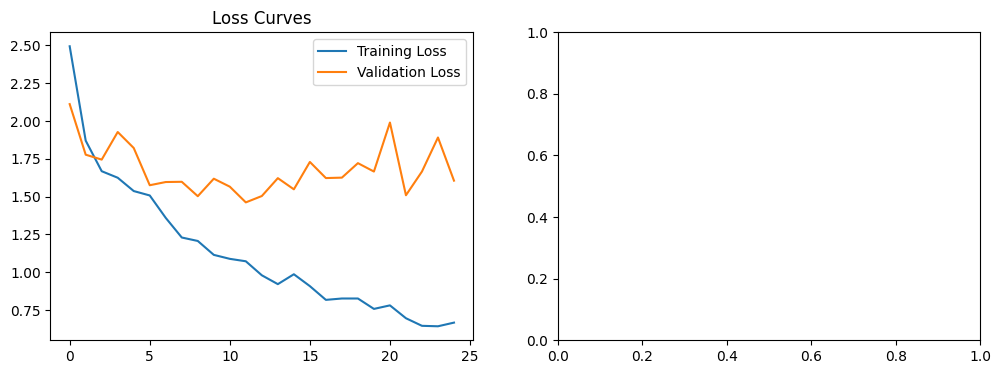

In [ ]:
deit_model = deit_model.to(device)
deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, {'train': train_loader_deit, 'val': val_loader_deit}, criterion, optimizer, num_epochs=25)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc.cpu(), label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


In [ ]:

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Load pre-trained DeiT model and adjust the classifier for your number of classes
# deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
# num_classes = len(classes) # classes is your list of classes
# deit_model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
# deit_model.to(device)

# # Define your loss function and optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(deit_model.parameters(), lr=0.001)

# num_epochs = 20

# # Start training
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader_deit, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = deit_model(inputs)
#         loss = criterion(outputs.logits, labels)
#         loss.backward()
#         optimizer.step()

#         # Print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0


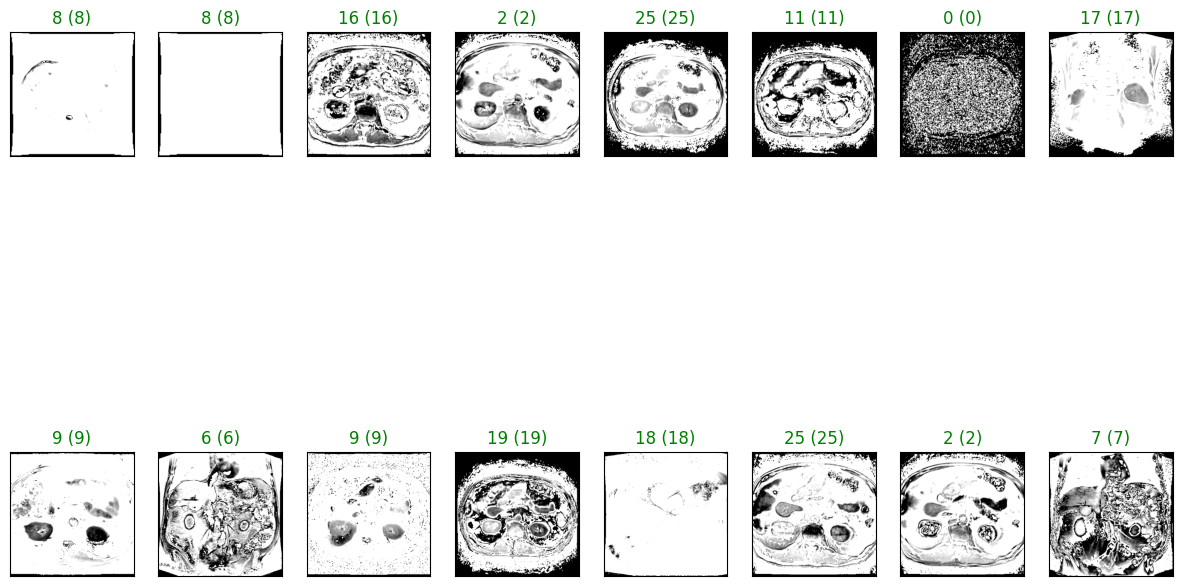

In [ ]:
# # Display a batch of predictions
# def visualize_results(model,dataloader,device):
#     model = model.to(device) # Send model to GPU if available
#     with torch.no_grad():
#         model.eval()
#         # Get a batch of validation images
#         images, labels = next(iter(test_loader))
#         images, labels = images.to(device), labels.to(device)
#         # Get predictions
#         _,preds = torch.max(model(images), 1)
#         preds = np.squeeze(preds.cpu().numpy())
#         labels = labels.cpu().numpy()

#     # Plot the images in the batch, along with predicted and true labels
#         mean = np.array([0.5])
#         std = np.array([0.5])
#         fig = plt.figure(figsize=(15, 10))
#         for idx in np.arange(len(preds)):
#           ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
#           image = images[idx].squeeze() # Remove the channel dimension
#           image = torch.mean(image, dim=0) # Average across the channel dimension
#           image = image.cpu().numpy()
#           image = std * image + mean
#           image = np.clip(image, 0, 1)
#           ax.imshow(image, cmap='gray')
#           ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
#             color=("green" if preds[idx]==labels[idx] else "red"))

#     return

# visualize_results(best_model,test_loader,device)

In [ ]:
class ImgDatasetForVis(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform

    def __len__(self):
        return self.data_df.shape[0]

    def __getitem__(self, idx):
        img_file = self.data_df.fname[idx]
        ds = pydicom.dcmread(img_file)
        img = np.array(ds.pixel_array, dtype=np.float32)
        img = img[np.newaxis]
        img = torch.from_numpy(np.asarray(img))
        if self.transform:
          img = self.transform(img)


        labl = self.data_df.label[idx]
        adjusted_label = classes.index(labl)
        y = torch.tensor(adjusted_label, dtype=torch.long)

        return img, y, img_file  # also return file path


# Create a data loader for visualization
vis_dataset = ImgDatasetForVis(test_df, data_transforms['test'])
vis_loader = DataLoader(vis_dataset, batch_size=batch_size, shuffle=False)
incorrect_dataset= ImgDatasetForVis(incorrect_df, data_transforms['test'])
incorrect_loader = DataLoader(incorrect_dataset, batch_size=batch_size, shuffle=False)



In [ ]:

def visualize_results2(model, dataloader, device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels, filenames = next(iter(dataloader))
        print(filenames)
        #original_images = images.clone() # Store a copy of original images
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()


    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(20, 20))
    grid_size = 4
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(grid_size, grid_size, idx+1, xticks=[], yticks=[])
        #image = original_images[idx].mean(dim=0) # Average across the channel dimension
        #image = image.cpu().numpy()

        ds = pydicom.dcmread(filenames[idx])
        # Extract pixel array
        image = ds.pixel_array
        # Convert to PIL image
        #image = Image.fromarray(image).convert('L')

        # Apply center crop
        #image = resize(image)

        # Convert back to NumPy array
        #image = np.array(image)
        # Convert to float and normalize
        #image = np.array(image).astype('float32')
        #image /= 255.0

        image = image * 1.5  # Increase brightness by a factor of 1.5

        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(classes[preds[idx]])]['short'], abd_label_dict[str(classes[labels[idx]])]['short']),
            color=("green" if preds[idx]==labels[idx] else "red"))

    return

('/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/16 (1-40)/0021.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/16 (41-80)/0061.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/18/0037.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/11/0037.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/7/0037.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/6/0037.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/17/0021.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/1/0007.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/10/0021.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/19/0045.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/8/0017.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/4/0037.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/15/0001.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/e

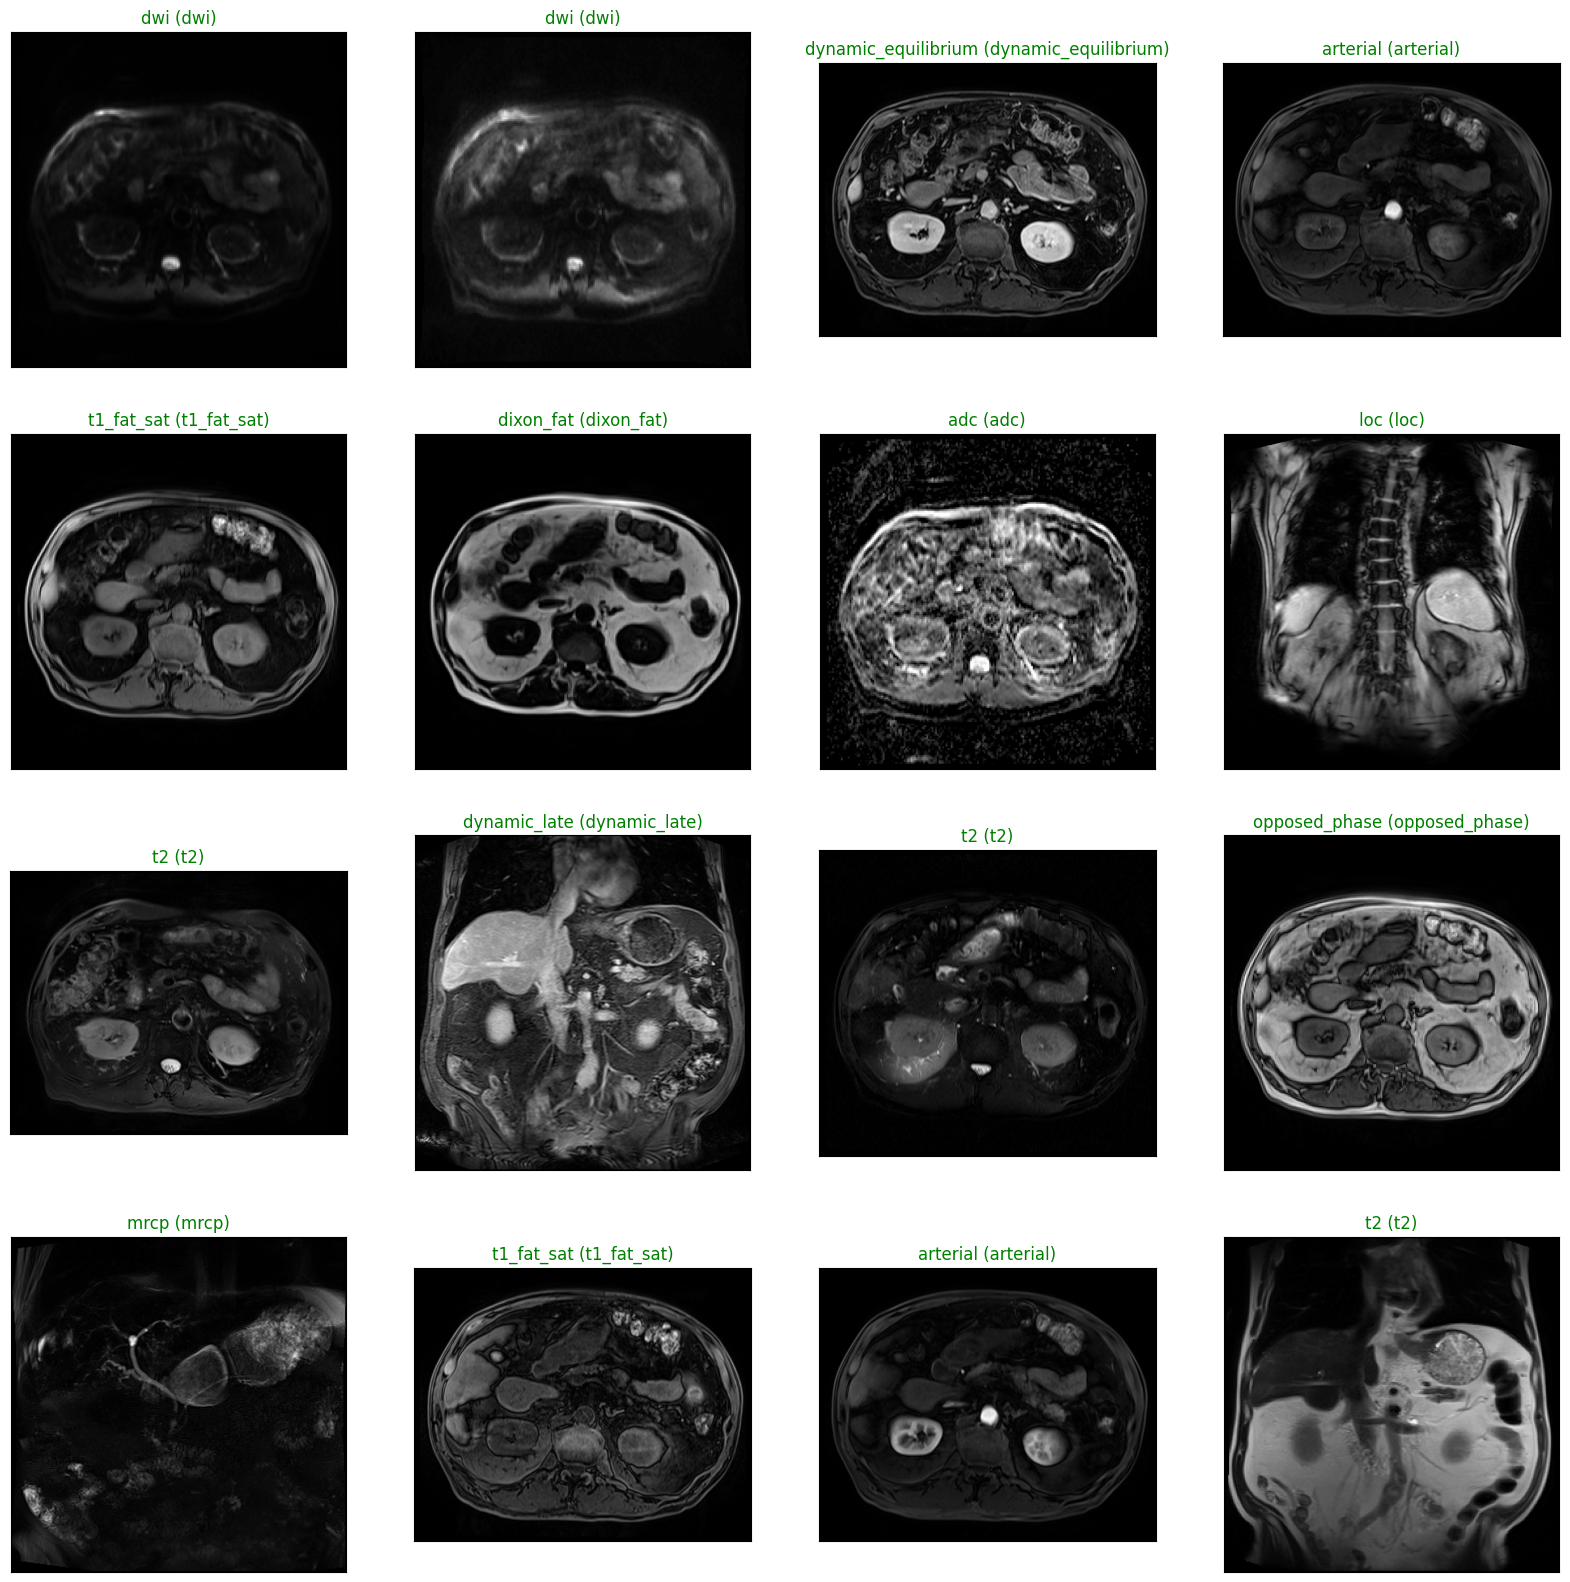

In [ ]:
# Now use 'vis_loader' in your visualization function
visualize_results2(best_model, vis_loader, device)

In [ ]:
## show incorrect predictions

def visualize_incorrect(df):

    # Get a batch of validation images
    filenames = df.fname
    preds = df.predictions
    labels = df.label



    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(50, 50))
    grid_size = 4
    fontsize = 24

    for idx, row in df.iterrows():
        #print(idx)
        ax = fig.add_subplot(int(len(df)/grid_size)+1, grid_size, idx+1, xticks=[], yticks=[])
        filename = row['fname']
        pred = row['predictions']
        label = row['label']


        #ax = fig.add_subplot(grid_size, int(len(preds)/grid_size), idx+1, xticks=[], yticks=[])
        #image = original_images[idx].mean(dim=0) # Average across the channel dimension
        #image = image.cpu().numpy()

        ds = pydicom.dcmread(filenames[idx])
        # Extract pixel array
        image = ds.pixel_array
        # Convert to PIL image
        #image = Image.fromarray(image).convert('L')

        # Apply center crop
        #image = resize(image)

        # Convert back to NumPy array
        #image = np.array(image)
        # Convert to float and normalize
        #image = np.array(image).astype('float32')
        #image /= 255.0

        image = image * 1.5  # Increase brightness by a factor of 1.5

        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(pred)]['short'], abd_label_dict[str(label)]['short']),
            color=("green" if pred==label else "red"), font_size=font_size)

    return

In [ ]:


def visualize_incorrect(df):
    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed

    # Set plot parameters for publication quality
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 14
    plt.rcParams['lines.linewidth'] = 2

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure()
    grid_size = 4

    for idx, row in df.iterrows():
        ax = fig.add_subplot(int(len(df)/grid_size)+1, grid_size, idx+1, xticks=[], yticks=[])
        filename = row['fname']
        pred = row['predictions']
        label = row['label']

        ds = pydicom.dcmread(filename)
        image = ds.pixel_array

        # Apply center crop
        image = center_crop(image)

        # Increase brightness
        image = image * 1.5

        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(pred)]['short'], abd_label_dict[str(label)]['short']),
                     color=("green" if pred==label else "red"))

        # Remove the axis labels
        ax.axis('off')

    plt.tight_layout()

    # Save the plot as a high-resolution image
    plt.savefig('publication-quality-plot_incorrect.png', dpi=300)

    plt.show()



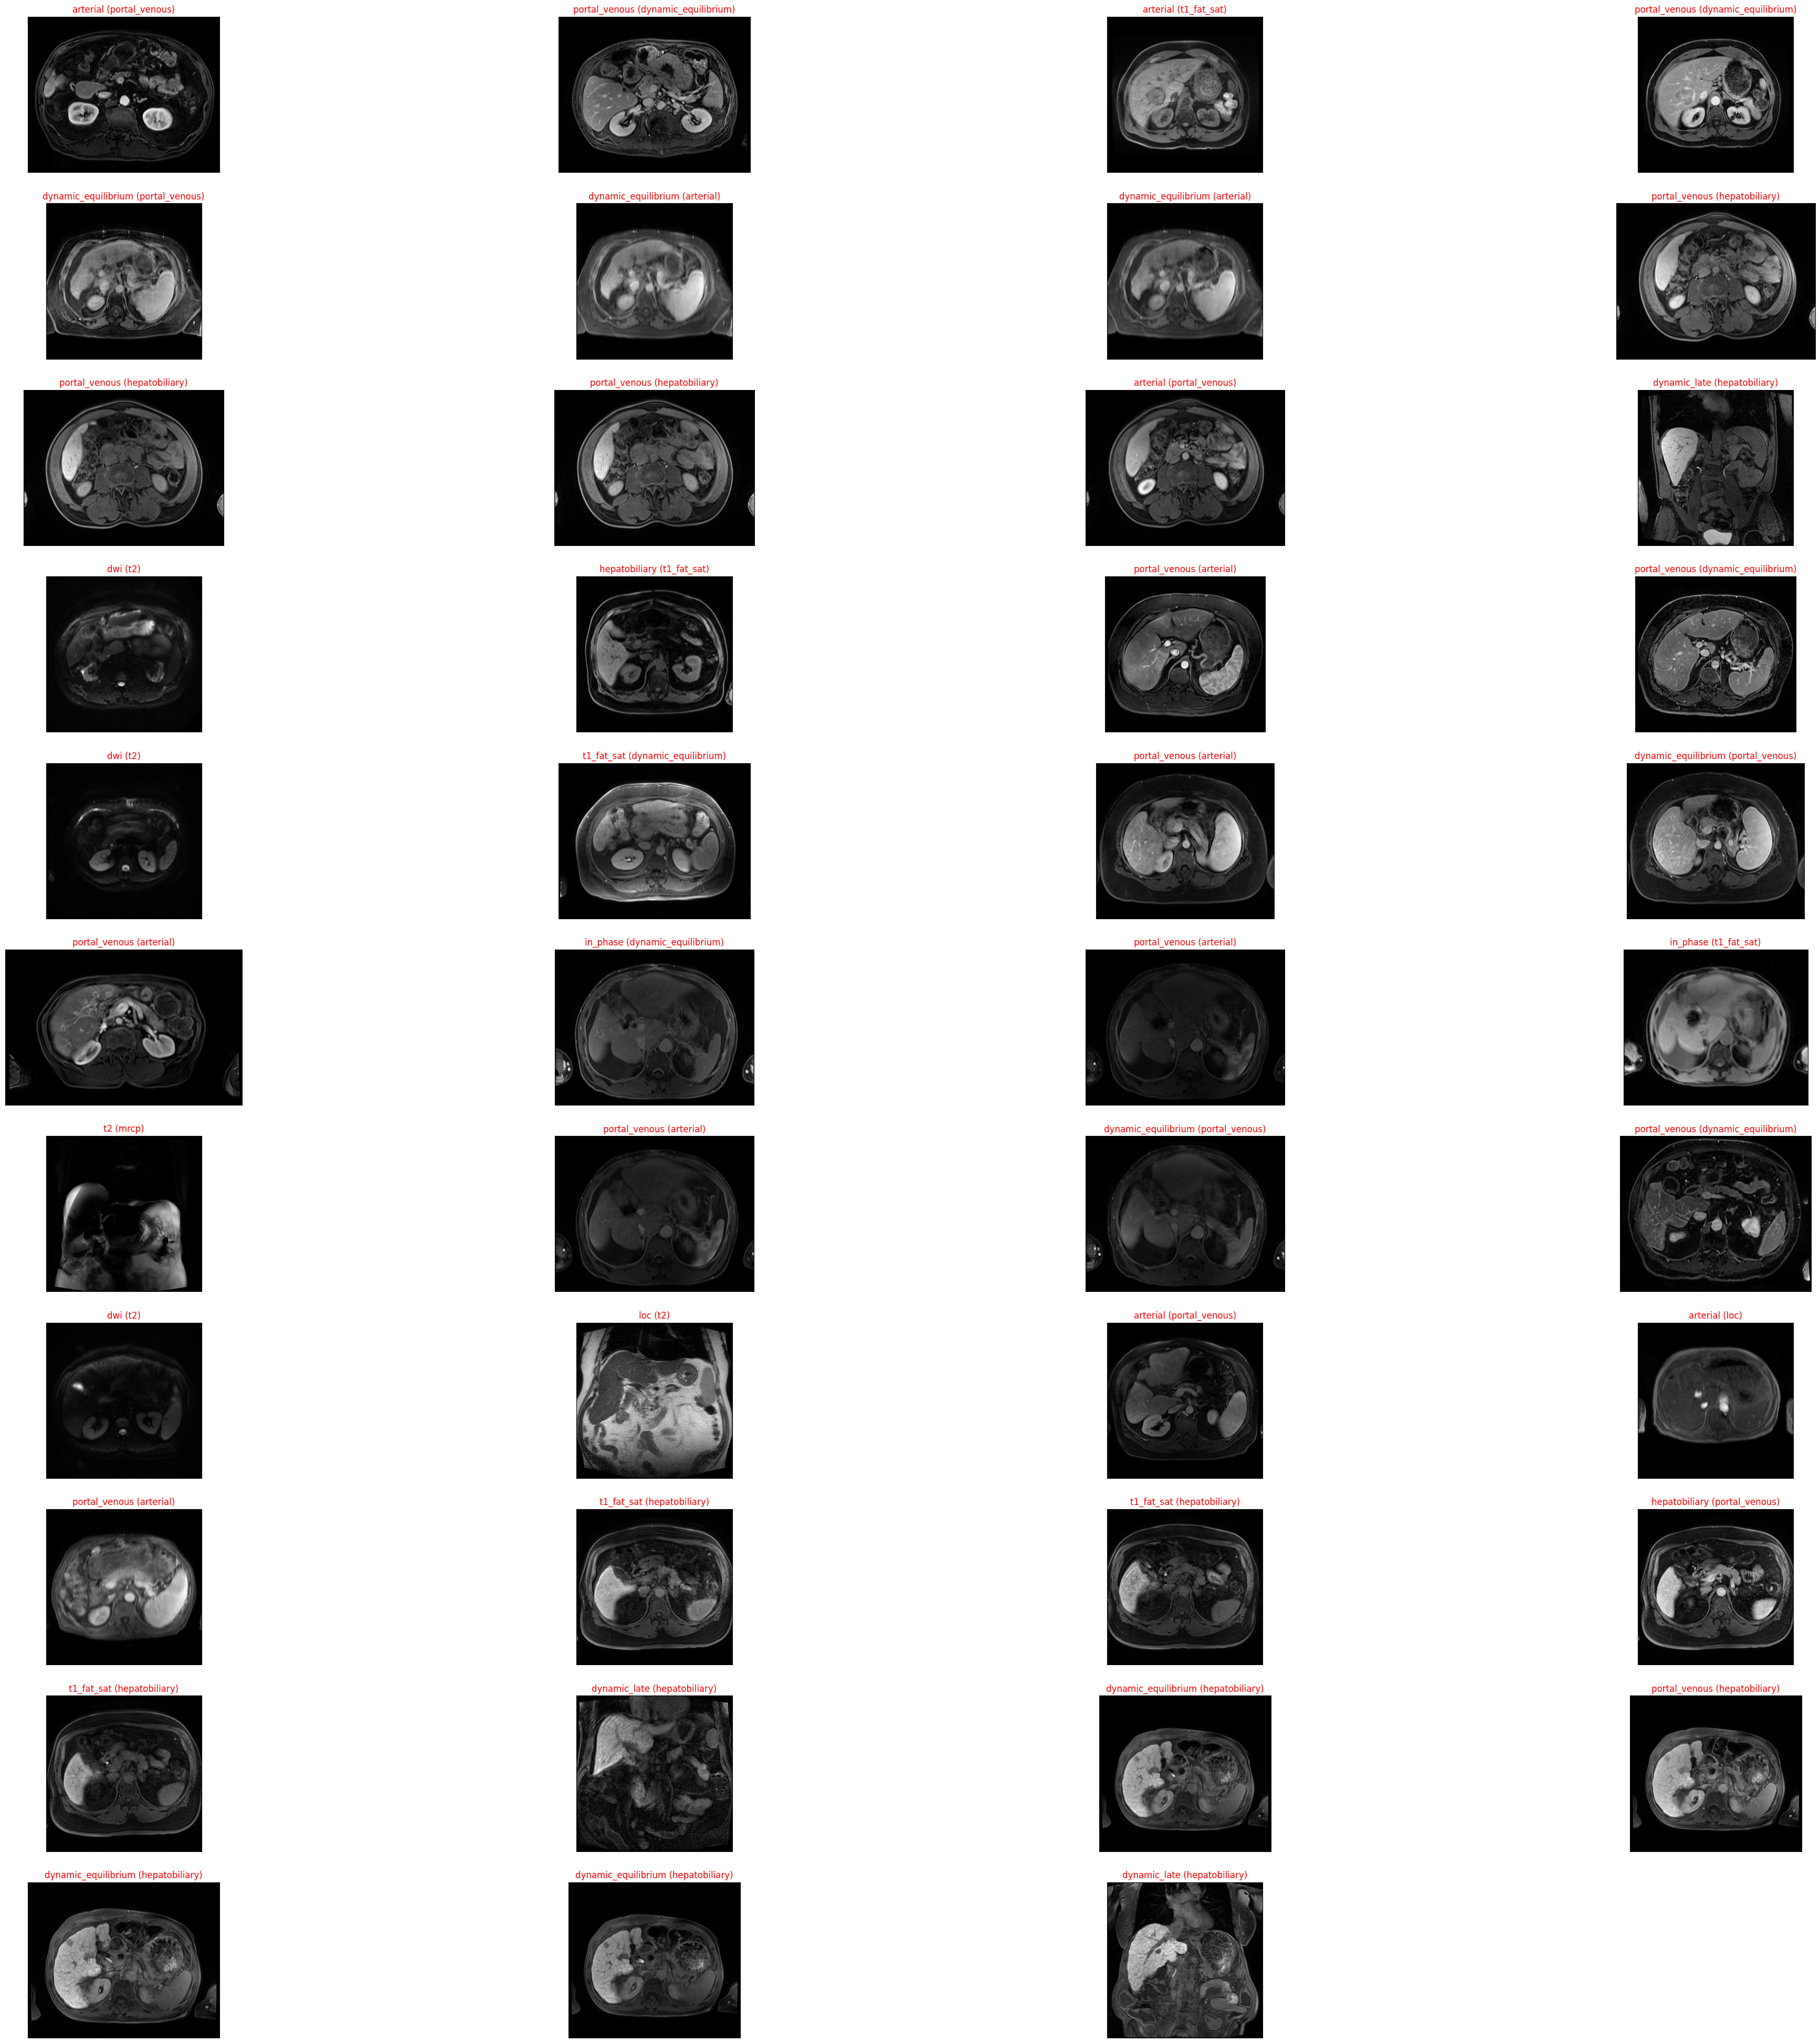

In [ ]:
visualize_incorrect(incorrect_df[:16])